## Use FNN for multi-class classification problem
In this notebook, we show how to use FNN to classify a multi-class dataset using soft max for output layer and cross entropy for cost function.


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import logging
logging.basicConfig(level=logging.DEBUG) # Enable this if you want extra debug info

np.random.seed(1)
sys.path.append(os.path.abspath('..'))

### Prepare Dataset
The code of the dataset was taken from course [CS231n Convolutional Neural Networks for Computer Vision by Andrej Karpathy Ng](https://cs231n.github.io/). It consist of C classes of points on a 2D planar following a helical distribution. Each sample is labeled with `Y=n` where `n` is the class of the point

Dataset, Train: 570, Test: 30


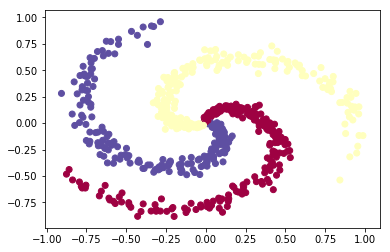

In [3]:
from examples.planar import load_spyral_dataset, plot_decision_boundary
from mynn.preprocess import StandardScaler

N=200
C=3
test_percent = 0.05
toys_X, toys_Y = load_spyral_dataset(N=N)
toys_X = toys_X.T
toys_Y = toys_Y.reshape(-1, 1).T
m = toys_X.shape[1]

# Shuffle examples
shuffle_args = np.random.permutation(toys_X.shape[1])
toys_X = toys_X[:,shuffle_args]
toys_Y = toys_Y[:,shuffle_args]

# Split test, train
split_point = int(m - m * test_percent)

train_X = toys_X[:,:split_point]
train_Y = toys_Y[:,:split_point]
test_X = toys_X[:,split_point:]
test_Y = toys_Y[:,split_point:]

# Center the dataset and normalize variance
scaler = StandardScaler()
scaler.train(train_X)
train_X = scaler.scale(train_X)
test_X = scaler.scale(test_X)

print(f"Dataset, Train: {train_X.shape[1]}, Test: {test_X.shape[1]}")
plt.scatter(toys_X[0, :], toys_X[1, :], c=toys_Y.squeeze(), cmap=plt.cm.Spectral)
plt.show()


### Train a 4-Layers FNN
We will use 4 hidden layer with `relu` activation function and one `softmax` output layer.


In [4]:
from mynn import FNN
from mynn.activation import ReLUActivation, SigmoidActivation, SoftmaxActivation
from mynn.optimizers import Adam, GradientDescent, RMSProp, GradientDescentMomentum
from mynn.regularization import DropoutRegularization, L2Regularization
from mynn.validation import performance_training_callback
from mynn.endecoders import OneHotEncoderDecoder
from mynn.loss import CrossEntropyLoss
from mynn.validation import performance_training_callback

layers = [
    (10, ReLUActivation),
    (7, ReLUActivation),
    (5, ReLUActivation),
    (3, SoftmaxActivation)
]

nn_parameters = {
    'layers_config': layers,
    'n_x': train_X.shape[0],
    'regularization': DropoutRegularization(keep_probs=[0.5, 0.8, 0.8, 1]),
    'optimizer': Adam(learning_rate=0.002),
    'loss_function': CrossEntropyLoss(),
    'output_encoder_decoder': OneHotEncoderDecoder(classes=list(range(0, C)))
}

epochs=500
nn = FNN(**nn_parameters)

costs_cb= performance_training_callback(
    [train_X, test_X],
    [train_Y, test_Y],
    every_nth_iteration=25,
    prediction_kwargs={'average':'micro'})
costs = nn.train(train_X, train_Y, epochs=epochs, iteration_callback=costs_cb, mini_batch_size=128)



DEBUG:mynn.network:Initialized FNN network of #4 layers
DEBUG:mynn.network:  Layers sizes: [10, 7, 5, 3]
DEBUG:mynn.network:  Activation functions: [ReLUActivation, ReLUActivation, ReLUActivation, SoftmaxActivation]
DEBUG:mynn.network:  Optimizer: Adam(learning_rate=0.002,beta=0.9,beta2=0.99)
DEBUG:mynn.network:  Regularization: DropoutRegularization(keep_probs=[0.5, 0.8, 0.8, 1])
DEBUG:mynn.network:  Encoder/Decoder: OneHotEncoderDecoder(classes=[0 1 2])
DEBUG:mynn.network:Training on X: (2, 570), Y: (1, 570) for 500 epochs.
DEBUG:mynn.network:Enabling mini-batch optimization with size=128
DEBUG:mynn.network:Shuffling dataset for improved optimization performance
DEBUG:mynn.network:Encoding Y variable
DEBUG:mynn.network:Epoch: 0, Batch: 0, Cost: 3.9638017953204496
DEBUG:mynn.network:Epoch: 7, Batch: 4, Cost: 4.31004636311472
DEBUG:mynn.network:Epoch: 25, Batch: 0, Cost: 3.609268515640304
DEBUG:mynn.network:Epoch: 32, Batch: 4, Cost: 4.0246406238953245
DEBUG:mynn.network:Epoch: 50, Bat

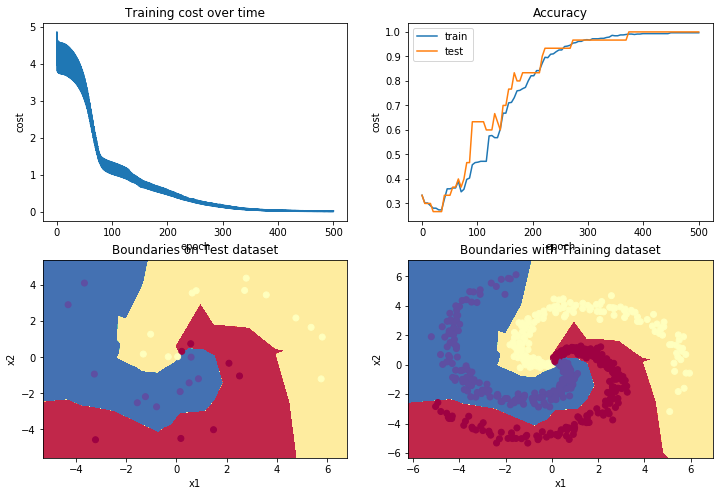

In [15]:
train_costs = np.array(list(map(lambda c: c[0], costs)))

def epochspace(epochs, values):
    """Generate a linear epochs space distributed on some observed variable"""
    return np.linspace(0, epochs, values.size)

def epoch_metric(costs, dataset_id, metric, with_epochspace=False, epochs=None):
    """Extra the extra metric from training costs."""
    costs =  np.array(list(map(lambda x: x[1][dataset_id][metric], filter(lambda x: x[1][0] is not None, costs))))
    if with_epochspace and epochs is not None:
        return np.linspace(0, epochs, costs.size), costs

plt.rcParams["figure.figsize"] = (12,8)
f, axarr = plt.subplots(2, 2, squeeze=False)
axarr[0][0].plot(epochspace(epochs, train_costs), train_costs)
axarr[0][0].set_xlabel('epoch')
axarr[0][0].set_ylabel('cost')
axarr[0][0].set_title('Training cost over time')

axarr[0][1].plot(*epoch_metric(costs, 0, 'accuracy', with_epochspace=True, epochs=epochs))
axarr[0][1].plot(*epoch_metric(costs, 1, 'accuracy', with_epochspace=True, epochs=epochs))
axarr[0][1].legend(['train', 'test'])
axarr[0][1].set_xlabel('epoch')
axarr[0][1].set_ylabel('cost')
axarr[0][1].set_title('Accuracy')

plot_decision_boundary(lambda x: nn.predict(x.T).reshape(-1,1), train_X, train_Y.reshape(-1), ax=axarr[1][1])
axarr[1][1].set_title('Boundaries with Training dataset')
plot_decision_boundary(lambda x: nn.predict(x.T).reshape(-1,1), test_X, test_Y.reshape(-1), ax=axarr[1][0])
axarr[1][0].set_title('Boundaries on Test dataset')
plt.show()

### Conclusions
From the cost over time plot we can see the the network had a smooth training. From the accuracy graph the model has a low bias and variance. With a final accuracy of ~100% on both training and test dataset.

The second row provides a visualization of the trained model by sampling the decision boundaries.